In [1]:
import warnings
notebook_warnings = []
def warning_collector(message, category, filename, lineno, file=None, line=None):
    notebook_warnings.append(f"{category.__name__}: {message} (File {filename}, line {lineno})")
warnings.showwarning = warning_collector


In [2]:
# -*- coding: utf-8 -*-
#  Copyright 2021 - 2022 United Kingdom Research and Innovation
#  Copyright 2021 - 2022 The University of Manchester
#  Copyright 2021 - 2022 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Jakob S. Jørgensen (DTU)
#                   Edoardo Pasca (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)
#                   Gemma Fardell (UKRI-STFC)

# Introductory demo of Core Imaging Library (CIL) 

### 3D laboratory micro-CT, cone-beam data of a walnut

This exercise walks through the steps needed to load in and reconstruct by FDK a 3D cone-beam dataset of a walnut, acquired by laboratory micro-CT.

Learning objectives are:
- Load and investigate a TXRM data set.
- Apply CIL's `TransmissionAbsorptionConverter`.
- Compute FDK reconstruction using CIL and compare with a reconstruction made from fewer projections.
- Write out the reconstructed image to a TIFF stack.

This example requires the dataset `walnut.zip` from https://zenodo.org/record/4822516 :

- https://zenodo.org/record/4822516/files/walnut.zip

If running locally please download the data and update the 'path' variable below.




In [3]:
path = '/mnt/share/materials/SIRF/Fully3D/CIL/Walnut'

In [4]:
# remove some annoying warnings
import logging
logger = logging.getLogger('dxchange')
logger.setLevel(logging.ERROR)

First import all of the modules we will need:

In [5]:
import os
from cil.io import ZEISSDataReader, TIFFWriter
from cil.processors import TransmissionAbsorptionConverter, Slicer
from cil.recon import FDK
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer, link_islicer

Load the 3D cone-beam projection data of a walnut:

In [6]:
filename = os.path.join(path, "valnut_2014-03-21_643_28/tomo-A/valnut_tomo-A.txrm")

data = ZEISSDataReader(file_name=filename).read()

The data is loaded in as a CIL `AcquisitionData` object:

In [7]:
type(data)

cil.framework.acquisition_data.AcquisitionData

We can call `print` for the data to get some basic information:

In [8]:
print(data)

Number of dimensions: 3
Shape: (1601, 1024, 1024)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



Note how labels refer to the different dimensions. We infer that this data set contains 1601 projections each size 1024x1024 pixels.

In addition to the data itself, `AcquisitionData` contains geometric metadata in an `AcquisitionGeometry` object in the `geometry` field, which can be printed for more detailed information:

In [9]:
print(data.geometry)

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -105.05081177,    0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0.        , 45.08757401,  0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1024 1024]
	Pixel size: [0.0658543 0.0658543]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1601
	Angles 0-9 in radians: [-3.1415665, -3.1377017, -3.1337626, -3.1298182, -3.125836 , -3.1219127,
 -3.1180956, -3.1140666, -3.1101887, -3.1062822]
	Angles 1591-1600 in radians: [3.106215 , 3.1101599, 3.1141102, 3.117992 , 3.12194  , 3.1258695,
 3.1298053, 3.1337383, 3.1376445, 3.1415997]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


CIL can illustrate the scan setup visually from the `AcquisitionData` geometry:

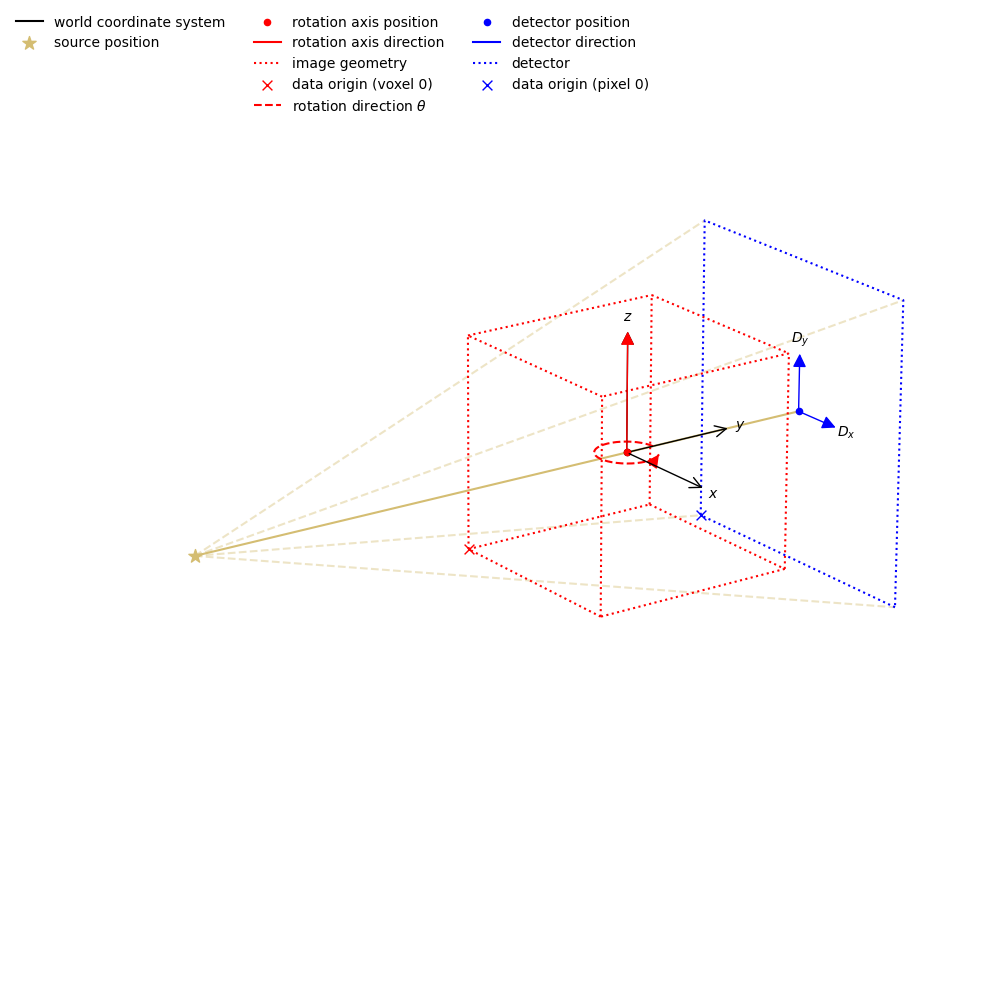

In [10]:
show_geometry(data.geometry);

We can use the dimension labels to extract and display 2D slices of data, such as a single projection:

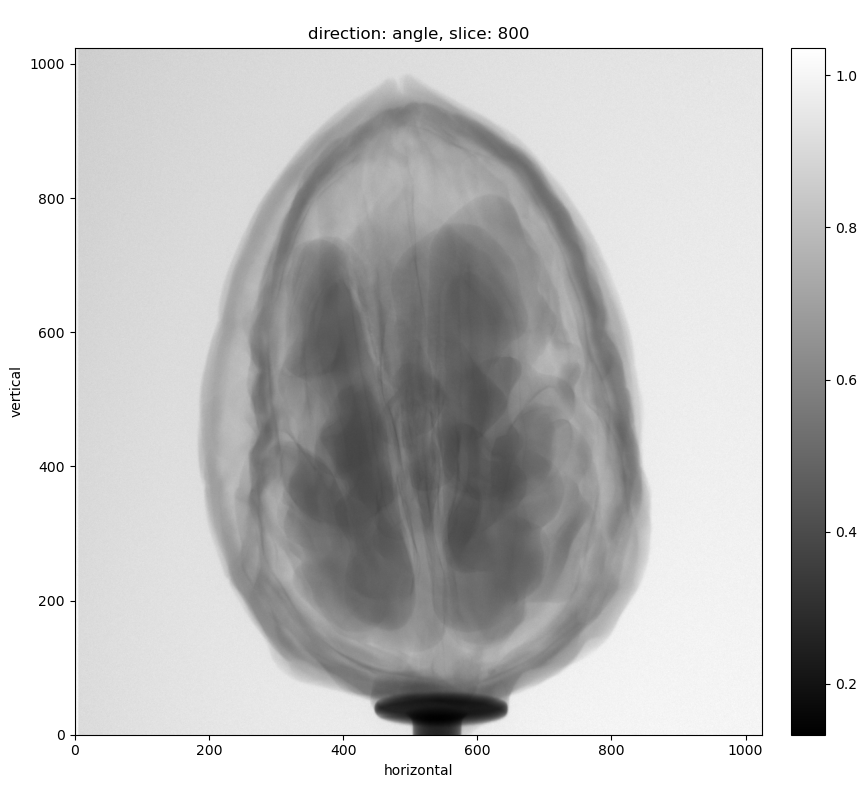

In [11]:
show2D(data, slice_list=('angle',800));

From the background value of 1.0 we infer that the data is transmission data (it is known to be already centered and flat field corrected) so we just need to convert to absorption/apply the negative logarithm, which can be done using a CIL processor, which will handle small/large outliers:

In [12]:
data = TransmissionAbsorptionConverter()(data)

We can also use a basic interactive viewer which will allow us to scroll through the various projections. [`islicer`](https://tomographicimaging.github.io/CIL/nightly/utilities.html#islicer-interactive-display-of-2d-slices) has a very similar interface to [`show2D`](https://tomographicimaging.github.io/CIL/nightly/utilities.html#show2d-display-2d-slices), but not quite the same.

In [13]:
islicer(data)

We again take a look at a slice of the data, now a vertical one to see the central slice sinogram after negative logarithm:

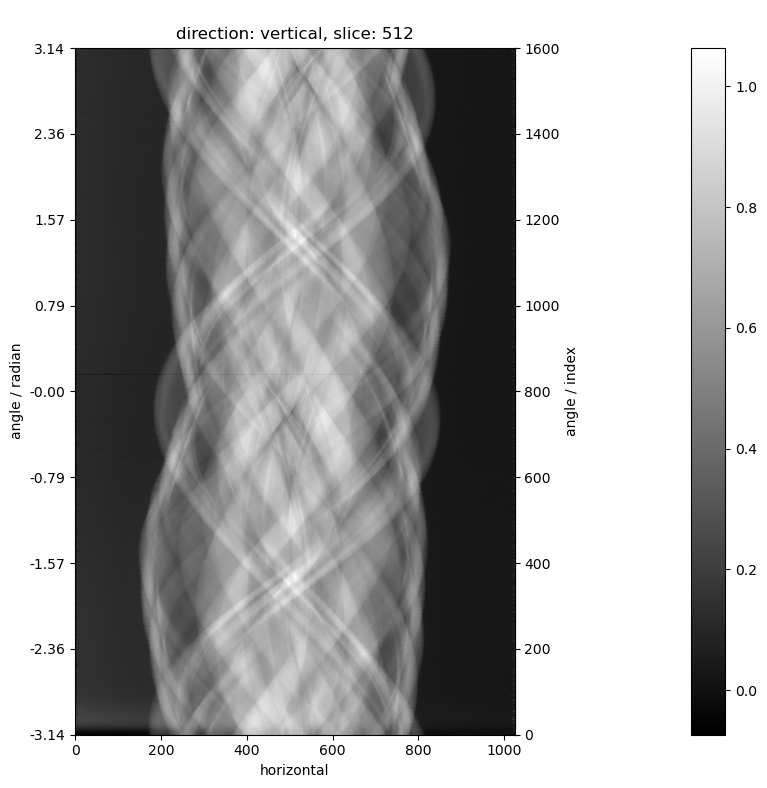

In [14]:
show2D(data, slice_list=('vertical', 512));

CIL supports different back-ends for which data order conventions may differ. Here we use the FDK algorithm from CIL's recon module. FDK is filtered back-projection for cone beam data. By default, the recon module uses TIGRE as a back-end, and requires us to permute the data array into the right order:

In [15]:
data.reorder(order='tigre')

The data is now ready for reconstruction. To set up the FDK algorithm we must specify the size/geometry of the reconstruction volume. Here we use the default one:

In [16]:
ig = data.geometry.get_ImageGeometry()

We can then create the FDK algorithm and reconstruct the data:

In [17]:
fdk =  FDK(data, ig)
recon = fdk.run()

FDK recon

Input Data:
	angle: 1601
	vertical: 1024
	horizontal: 1024

Reconstruction Volume:
	vertical: 1024
	horizontal_y: 1024
	horizontal_x: 1024

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



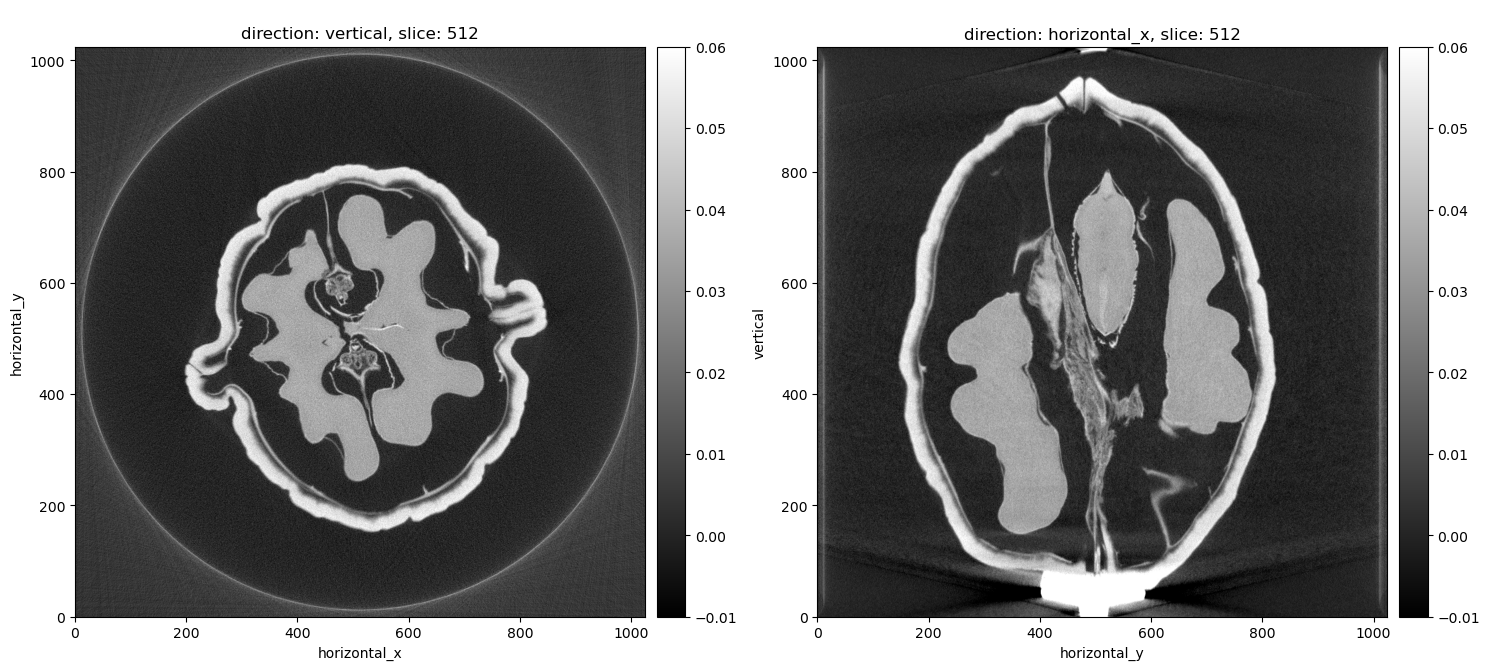

In [18]:
show2D(recon, slice_list=[('vertical',512), ('horizontal_x', 512)], fix_range=(-0.01, 0.06));

We can also interact with the data with `islicer`

In [19]:
islicer(recon, direction='vertical', minmax=(-0.01, 0.06))


In [20]:
islicer(recon, direction='horizontal_x', minmax=(-0.01, 0.06))

We can save the reconstructed volume to disk for example as a stack of TIFFs:

In [21]:
# save_base_path = os.getcwd()
# save_path = os.path.join(save_base_path, 'walnut')
# os.makedirs(save_path)

# TIFFWriter(data=recon, file_name=os.path.join(save_path, "out"), compression='uint16').write()

We now demonstrate the effect of reducing the number of projections on the FDK reconstruction.

In [22]:
from cil.processors import Slicer

reduce_factor = 10

data_reduced = Slicer(roi={'angle': (0,-1,reduce_factor)})(data)

ig = data_reduced.geometry.get_ImageGeometry()
fdk =  FDK(data_reduced, ig)
recon_reduced = fdk.run()

New geometry:  3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -105.05081177,    0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0.        , 45.08757401,  0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1024 1024]
	Pixel size: [0.0658543 0.0658543]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 160
	Angles 0-9 in radians: [-3.1415665, -3.1022923, -3.0630562, -3.0237632, -2.9845278, -2.945264 ,
 -2.9060063, -2.866688 , -2.8274012, -2.78817  ]
	Angles 150-159 in radians: [2.748842 , 2.7881632, 2.8274217, 2.866726 , 2.9059432, 2.9452505,
 2.9844823, 3.0237305, 3.0630383, 3.1023333]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (160, 1024, 1024)
New geometry shape:  (160, 102

We show the same slices as before:

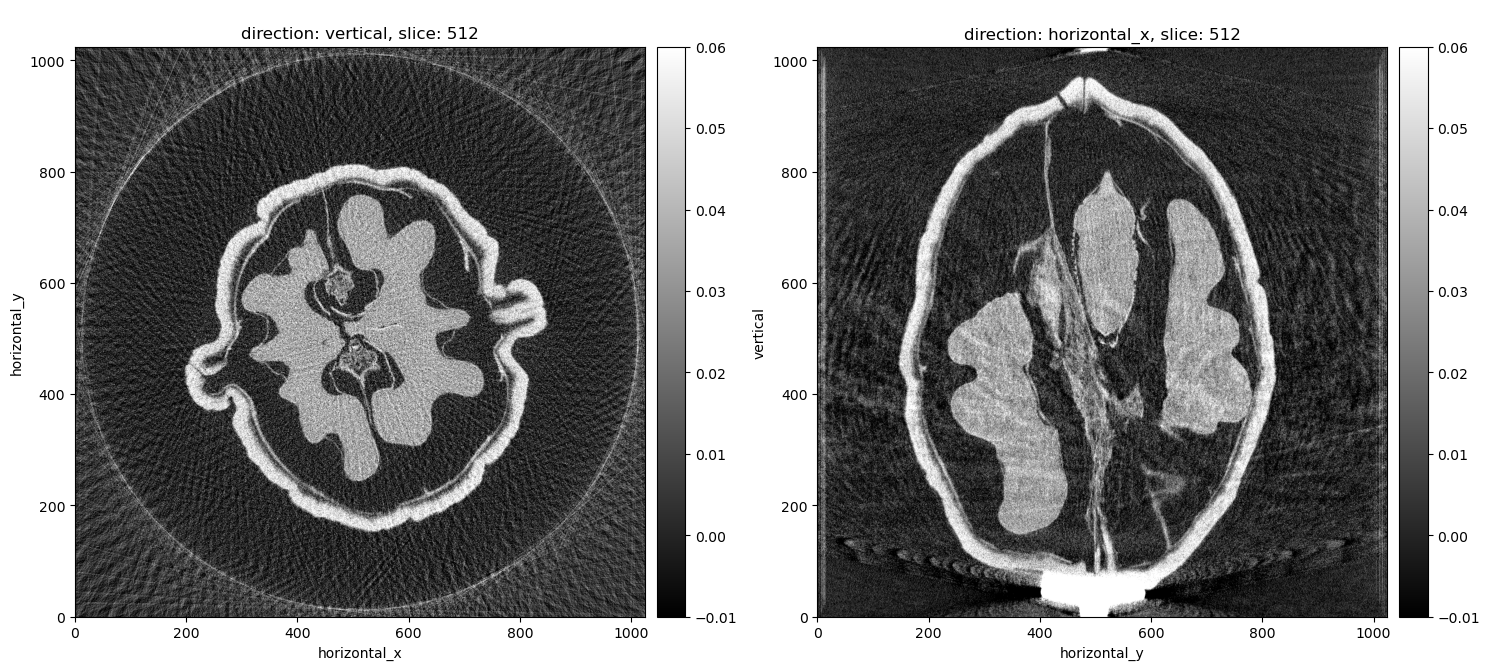

In [23]:
show2D(recon_reduced, slice_list=[('vertical',512), ('horizontal_x', 512)], fix_range=(-0.01,0.06));

We could also visually check the difference between the 2 reconstructions, interactively with `islicer` or compare side-by-side the reconstructions with `show2D`.

In [24]:
sl1 = islicer(recon, minmax=(-0.01, 0.06))
sl2 = islicer(recon_reduced, minmax=(-0.01, 0.06))
link_islicer(sl1, sl2)

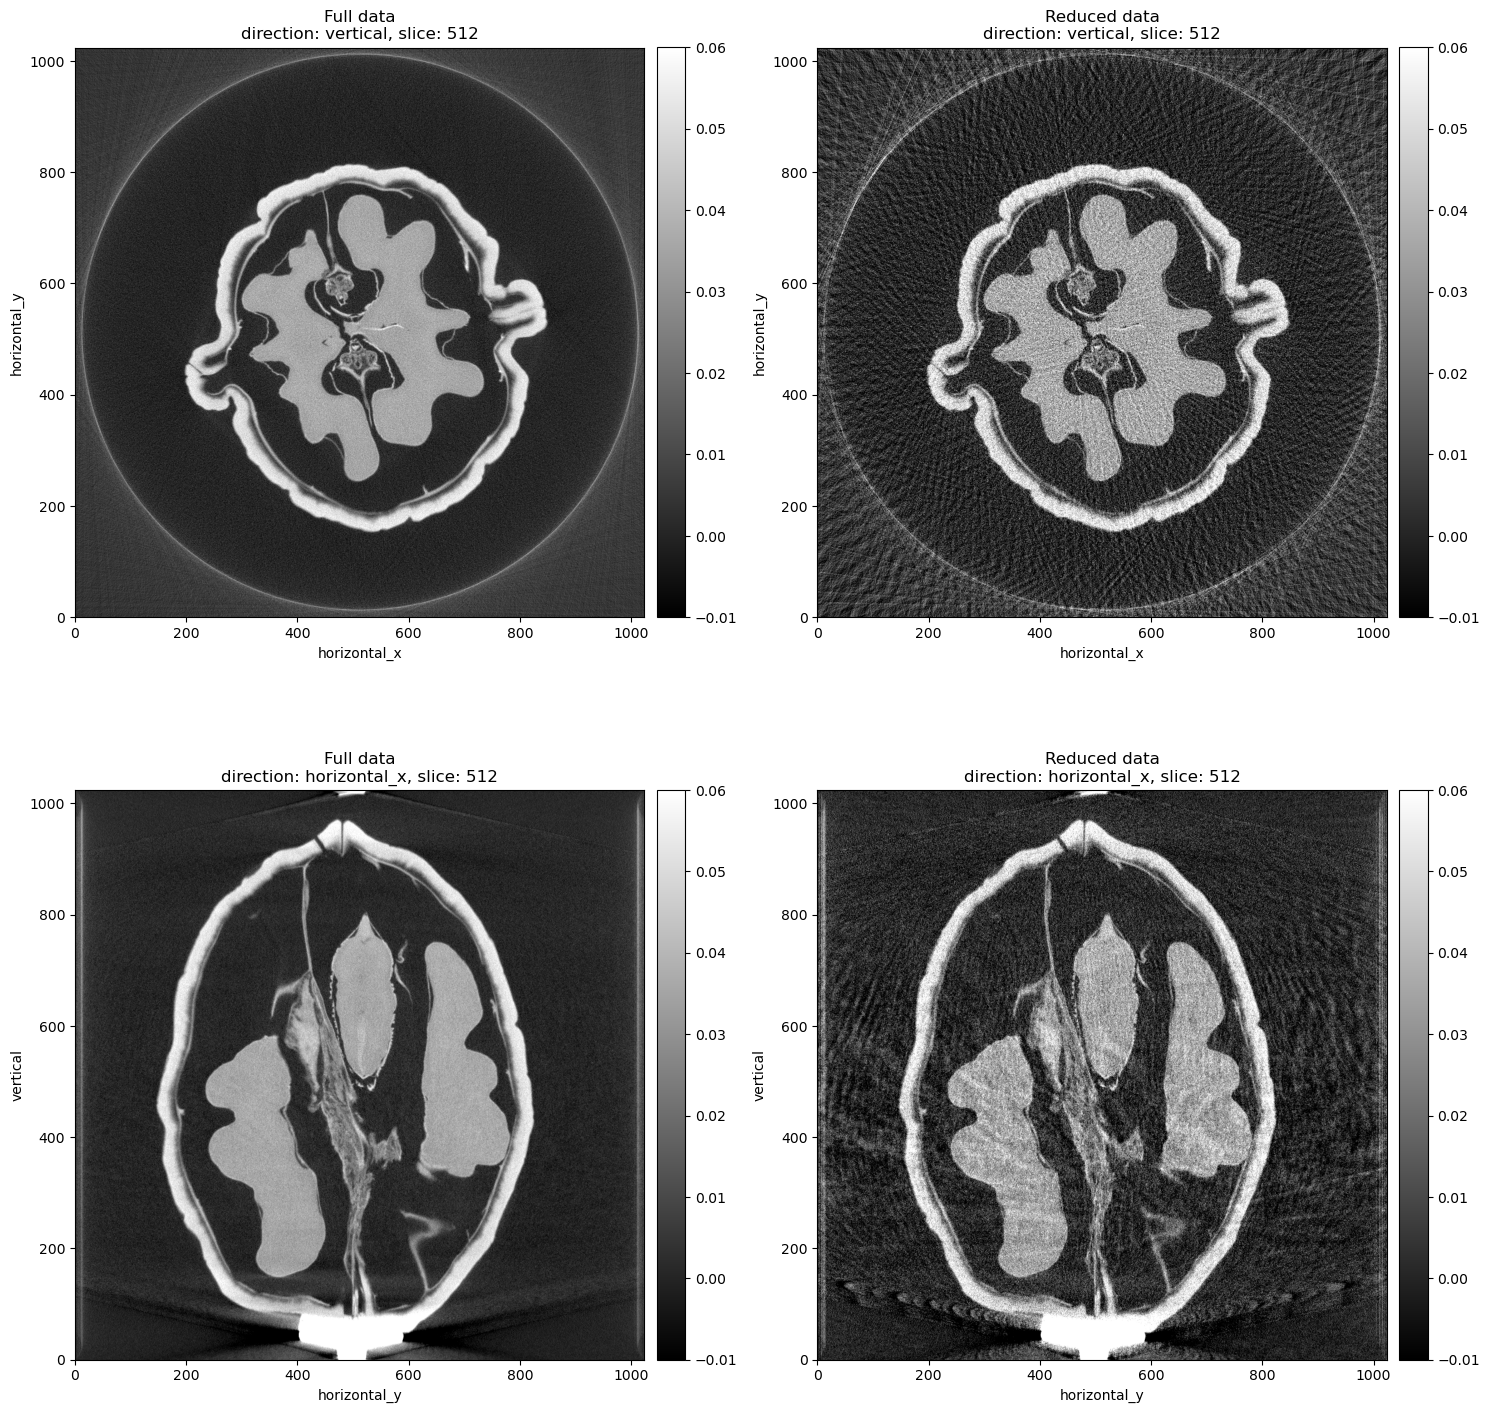

In [25]:
show2D([recon, recon_reduced, recon, recon_reduced], 
       title=['Full data', 'Reduced data', 'Full data', 'Reduced data'], 
       slice_list=[('vertical',512), ('vertical',512), ('horizontal_x', 512), ('horizontal_x', 512)], 
       fix_range=(-0.01,0.06));

In the vertical slice of the data, a ring can be seen. This is an edge artifact common in FBP reconstruction. We can remove it from our image using a circular mask.

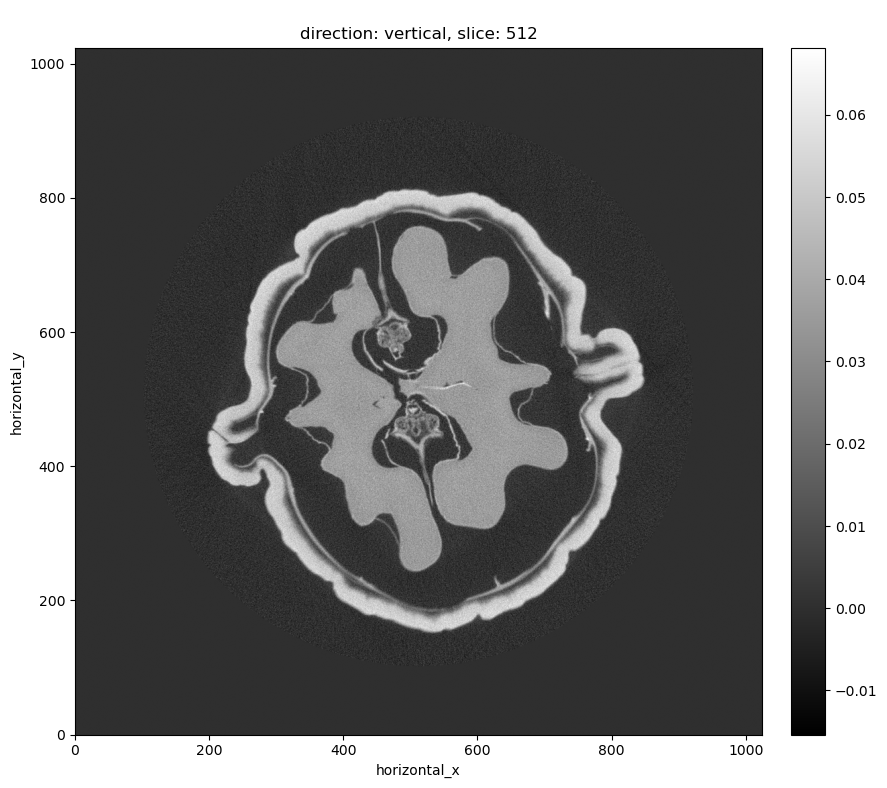

In [26]:
recon.apply_circular_mask(radius=0.8, in_place=True)

show2D(recon);

Alternatively, the ring can be prevented by padding the AcquisitionData before reconstruction, to ensure that all data is within the field of view. We'll learn about padding in [02_intro_sandstone_parallel_roi](./02_intro_sandstone_parallel_roi.ipynb)